In [48]:
import pandas as pd
import sys, os, gc
sys.path.append("/home/fvalle/phd/master_thesis/hsbm/")
sys.path.append("/home/fvalle/phd/master_thesis/")
os.chdir("/home/fvalle/phd/datasets/unbalanced/")

In [3]:
#GTEx
df = pd.read_csv('https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz', skiprows=2, compression='gzip', sep='\t')
df['ensg'] = [x[:15] for x in df['Name']]
df.set_index('Name', inplace=True)
df.set_index(['ensg'],inplace=True)
df=df.drop(['Description'],1)
genelist=pd.read_csv("https://stephenslab.github.io/count-clustering/project/utilities/gene_names_all_gtex.txt", header=None).values.ravel()
df = df[df.index.isin(genelist)]
df_file = pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep='\t').loc[:,['SAMPID','SMTS', 'SMTSD']]
df_file.set_index('SAMPID', inplace=True)

In [4]:
df_file.groupby('SMTS').count().sort_values('SMTSD',ascending=False)

,SMTSD
SMTS,
Blood,3480
Brain,3326
Skin,2014
Esophagus,1582
Blood Vessel,1473
Adipose Tissue,1327
Heart,1141
Muscle,1132
Lung,867


In [55]:
df_ub = df.reindex(columns=df_file[df_file['SMTS'].isin(['Stomach', 'Uterus', 'Kidney'])].index).dropna(how='all', axis=1)

In [56]:
import scanpy as sc

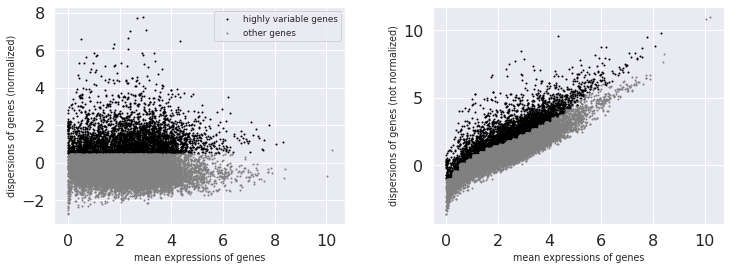

In [57]:
adata = sc.AnnData(X=df_ub.transpose(), obs=df_file.reindex(index=df_ub.columns))
sc.pp.log1p(adata, copy=False)
sc.pp.highly_variable_genes(adata, min_mean=0, max_mean=10, n_bins=40)
sc.pl.highly_variable_genes(adata, save="hvg.svg")

In [58]:
hvg = adata.var[adata.var['highly_variable']==True].sort_values(by='dispersions_norm', ascending=False).index
samples = adata.obs.index

In [59]:
df_hsbm = df.reindex(index=hvg[:1000], columns = samples).applymap(lambda x: pd.np.log2(x+1)*1e2)
df_hsbm

SAMPID,GTEX-1117F-2426-SM-5EGGH,GTEX-111CU-0926-SM-5EGIK,GTEX-111YS-1126-SM-5GZYQ,GTEX-1122O-1926-SM-5EGIQ,GTEX-113JC-2226-SM-5EGJG,GTEX-117YW-2226-SM-5N9DB,GTEX-117YX-1026-SM-5H11V,GTEX-11DXX-1326-SM-5GIDZ,GTEX-11DXX-1526-SM-5H115,GTEX-11EI6-2426-SM-5PNVS,...,GTEX-ZXES-1426-SM-5NQ8S,GTEX-ZY6K-0726-SM-5A5L8,GTEX-ZYFG-1326-SM-5GICJ,GTEX-ZYFG-1626-SM-5GZYY,GTEX-ZYT6-2226-SM-5GIC9,GTEX-ZYVF-0526-SM-5E43E,GTEX-ZYVF-2726-SM-5GID4,GTEX-ZYY3-1726-SM-5EGH3,GTEX-ZZ64-0426-SM-5E43F,GTEX-ZZPU-1426-SM-5GZZ6
ensg,,,,,,,,,,,,,,,,,,,,,
ENSG00000172179,430.524097,301.792191,9.446580,273.118324,287.499364,385.897561,328.318098,16.774328,363.226822,15.471281,...,0.000000,274.695764,0.000000,0.000000,25.302110,85.175903,10.492704,265.145358,11.645792,15.561972
ENSG00000170477,205.935528,180.694266,152.656966,152.707034,83.057985,190.958112,273.876784,173.682132,399.186193,189.219671,...,77.382758,196.569195,152.406368,168.840419,149.262233,251.298533,276.807844,133.856704,247.378691,161.635770
ENSG00000171401,369.153416,315.769051,197.379493,290.650583,133.799646,233.685464,302.962957,276.468585,574.711882,202.821551,...,126.663664,229.042440,272.355856,252.381284,252.155333,340.231288,413.093087,265.420638,330.873947,203.491998
ENSG00000115138,423.189316,424.260251,34.494209,371.479501,306.574463,195.977016,308.099869,144.466707,411.270013,326.423615,...,48.974843,280.281360,73.526221,143.616184,390.110824,138.183708,245.496547,319.723635,219.503257,117.823658
ENSG00000163209,238.377340,191.264986,114.860877,207.141946,110.567808,133.742566,230.946726,192.599942,331.208426,129.042440,...,97.401528,148.129894,222.527493,134.027740,146.936505,243.776039,269.220399,160.169652,248.259018,135.783348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000164442,706.608919,570.376518,497.636364,494.063661,870.597790,529.388543,492.314918,421.800615,637.382219,572.819264,...,456.985561,483.541884,469.766263,598.481717,609.465834,630.414594,670.459535,432.624970,483.693401,620.925839
ENSG00000107968,463.923216,245.654334,279.742808,237.601249,555.489578,534.766566,256.632809,313.109555,365.306002,371.918344,...,281.741861,265.374794,184.358192,297.195734,201.792191,528.762004,499.322147,318.173866,258.375975,373.660488
ENSG00000170776,658.150190,413.750352,455.887985,366.562016,609.761080,536.246989,446.139759,441.818995,570.708299,381.557543,...,426.603689,384.599177,410.433666,371.808758,263.505783,656.757587,437.225565,448.671437,427.575205,405.398017


In [60]:
df_hsbm.to_csv("mainTable.csv", index=True, header=True)
df_file[df_file.index.isin(df_hsbm.columns)].to_csv("files.dat", index=True, header=True)

In [61]:
gc.collect()

4691

In [62]:
from sbmtm import sbmtm

In [64]:
if model:
    del model
    model = sbmtm()
    gc.collect()

In [ ]:
model.load_graph("graph.xml.gz")

In [65]:
model.make_graph_from_BoW_df(df_hsbm)
model.save_graph("graph.xml.gz")

In [66]:
model.fit(verbose=True, parallel=True)

    l=1  Current bracket: (2, 2, 2) (39.851377958305804, 39.851377958305804, 39.851377958305804)
    l=1  Current bracket: (2, 2, 2) (39.851377958305804, 39.851377958305804, 39.851377958305804)
    l=1  Bisect at B = 2 with S = 39.8513779583058
    l=1  Best result: B = 2, S = 39.8513779583058
level 1 : rejected replacement (2, 1) -> (2, 2) , dS: 1.386294361203909
    l=1  Current bracket: (2, 2, 2) (39.851377958305804, 39.851377958305804, 39.851377958305804)
    l=1  Current bracket: (2, 2, 2) (39.851377958305804, 39.851377958305804, 39.851377958305804)
    l=1  Bisect at B = 2 with S = 39.8513779583058
    l=1  Best result: B = 2, S = 39.8513779583058
level 1 : rejected insert 2 , dS: 2.772588722407818
    l=0      B: 980 <- 1590    shrinking 1590 -> 1223
    l=0      B: 980 <- 1590    B=1223  niter:     1  count:    0  breaks:  0  min_S: 4920581.3  max_S: 4966766.8  S: 4920581.3  ΔS:     -46185.5  moves:    53 
    l=0      B: 980 <- 1590    B=1223  niter:     2  count:    0  breaks

Saving level 2
Saving level 1
Saving level 0


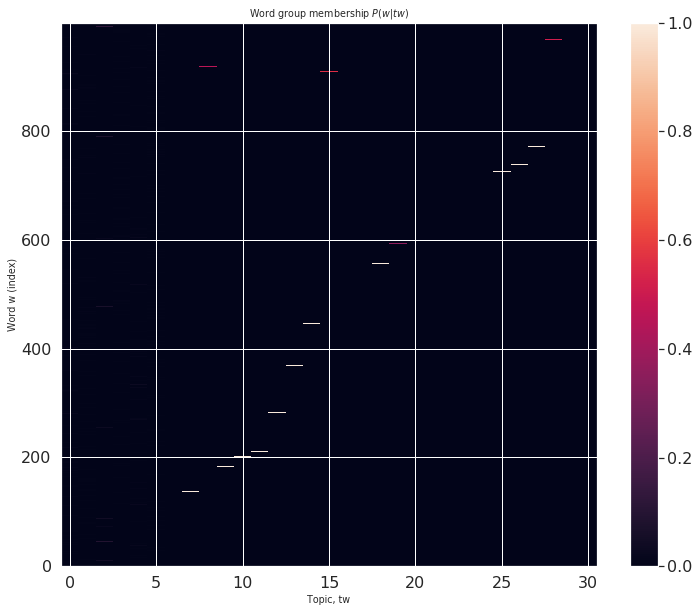

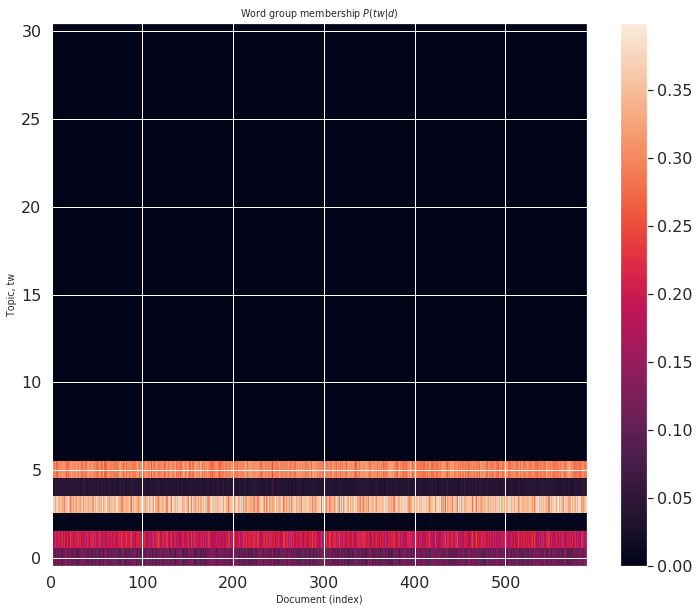

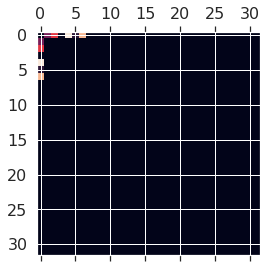

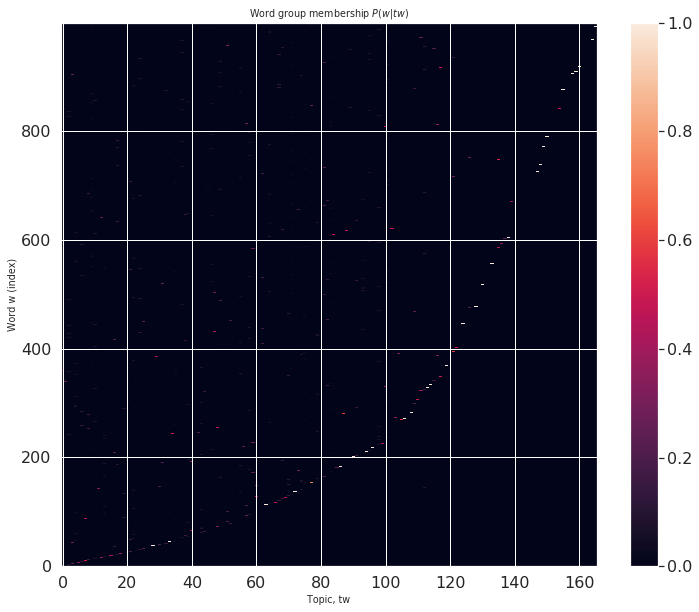

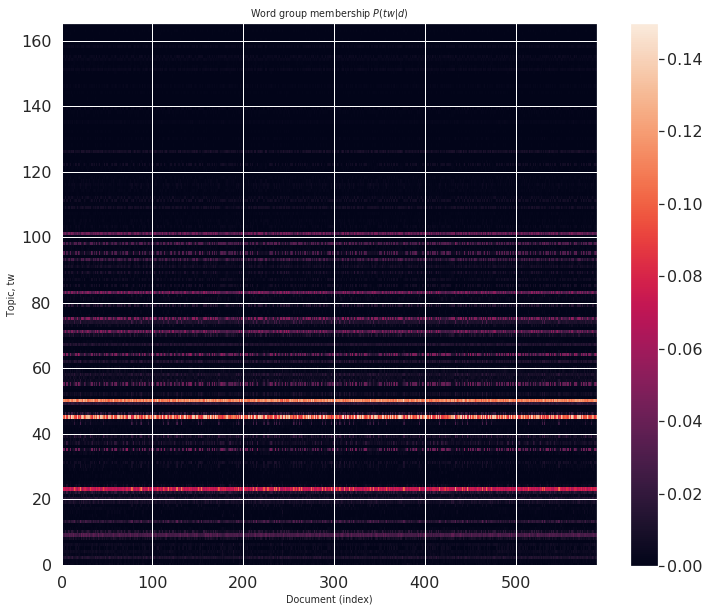

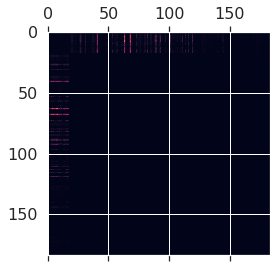

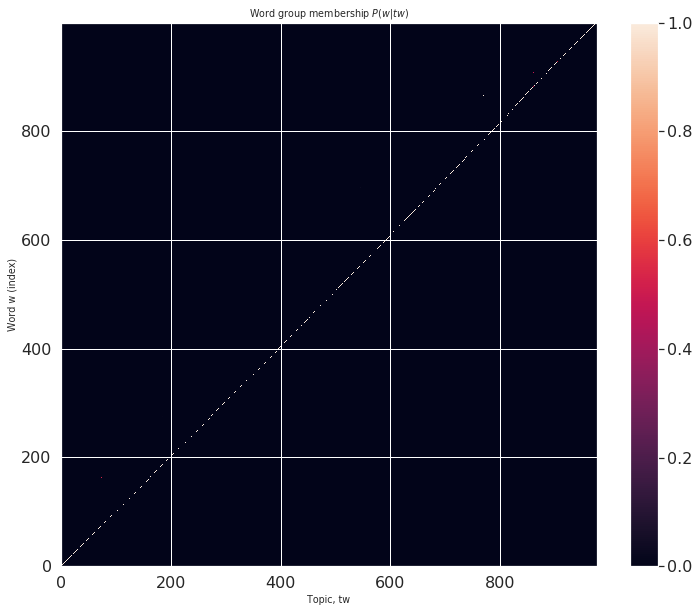

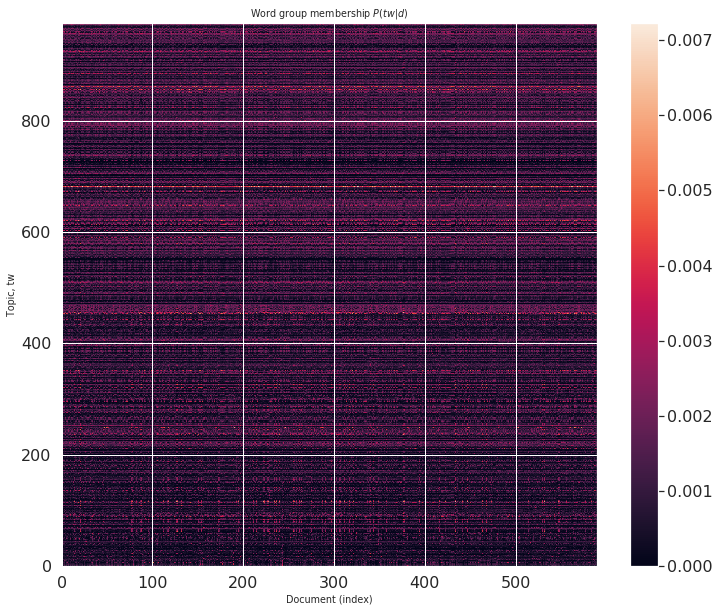

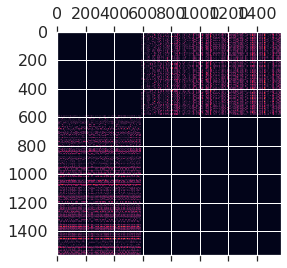

In [67]:
model.save_data()

In [68]:
from hsbmpy import clusteranalysis
from hsbmpy import get_max_available_L

True SMTS 2


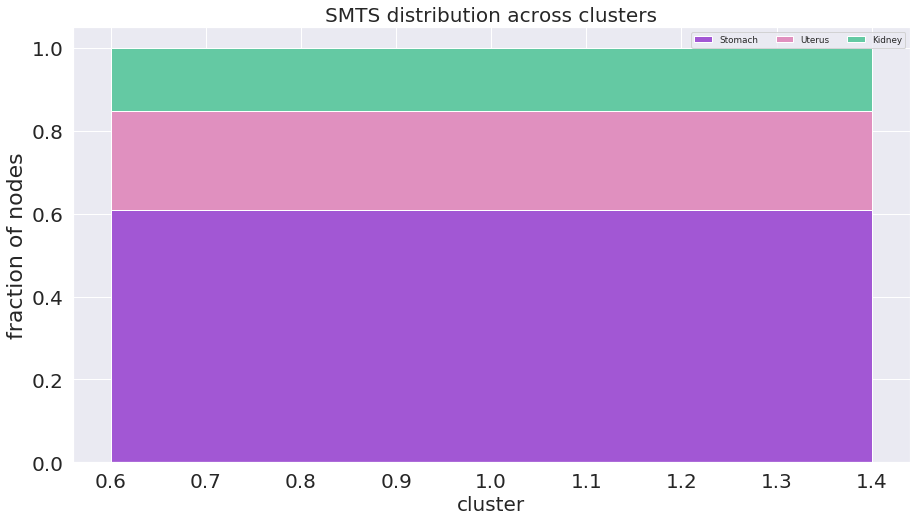

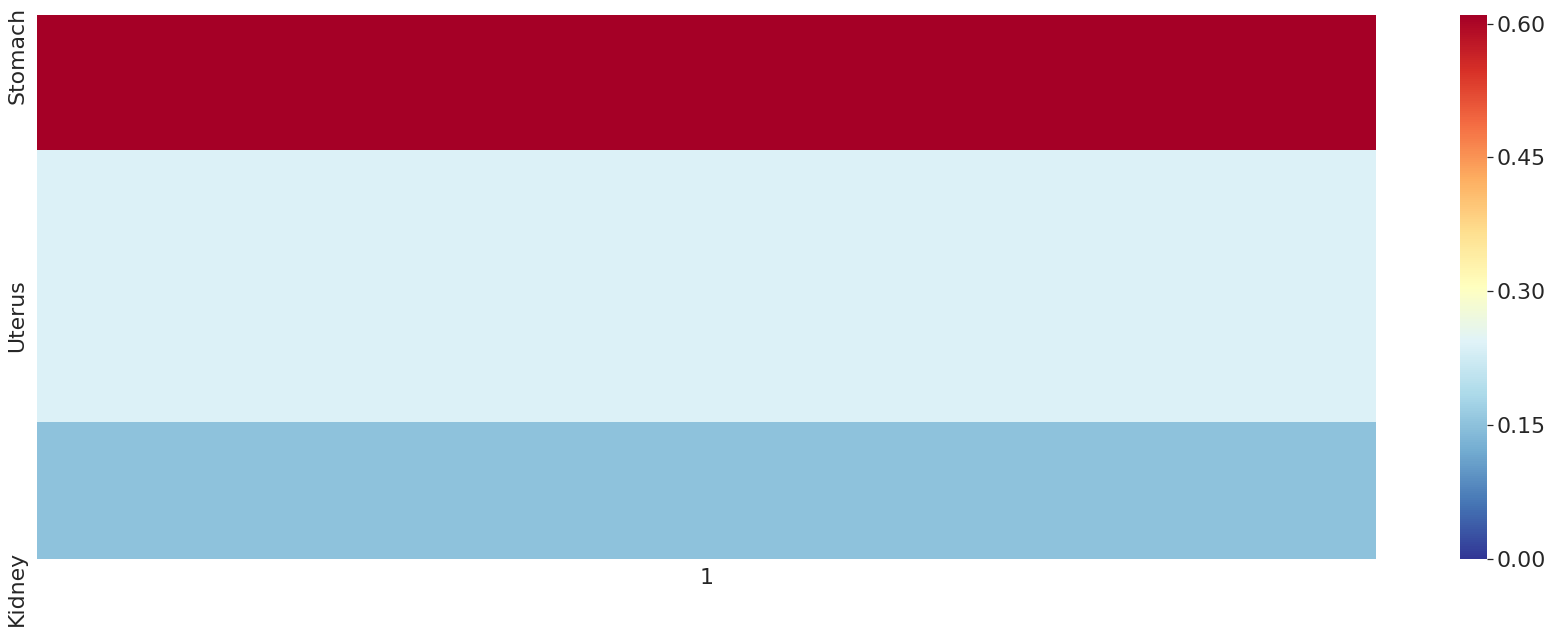

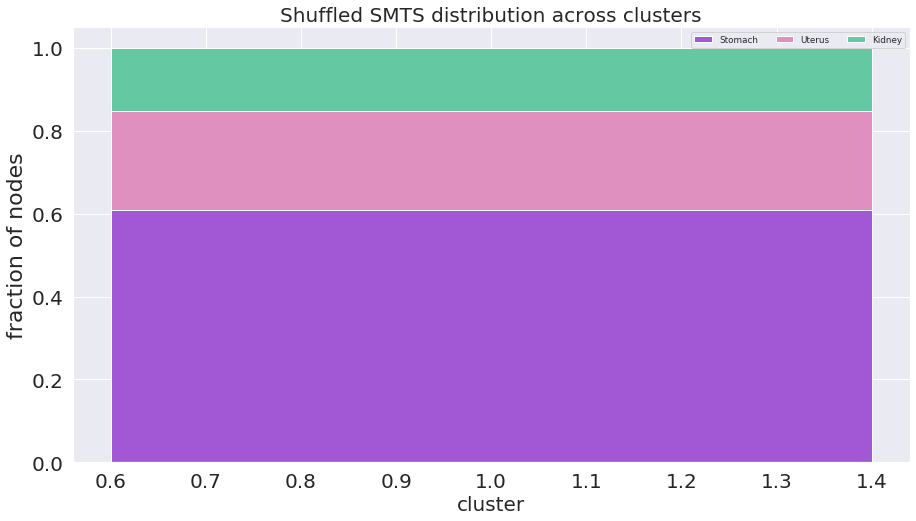

True SMTS 1


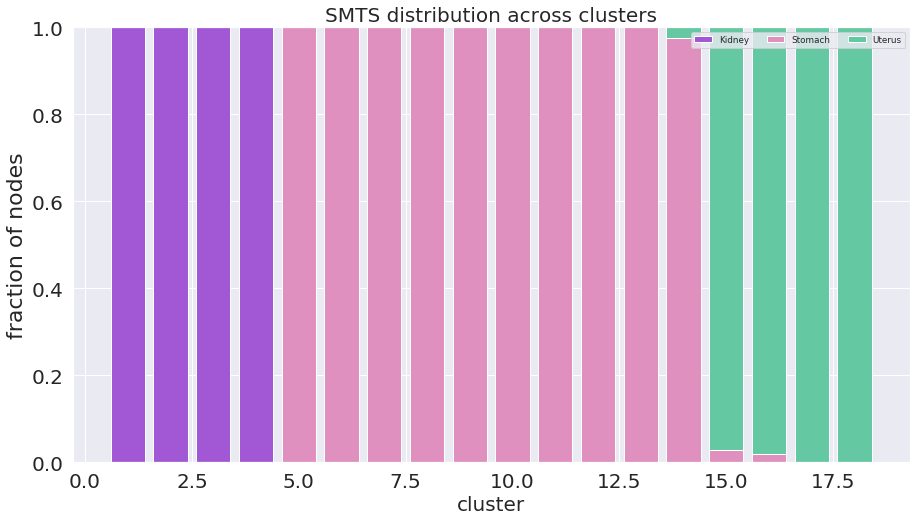

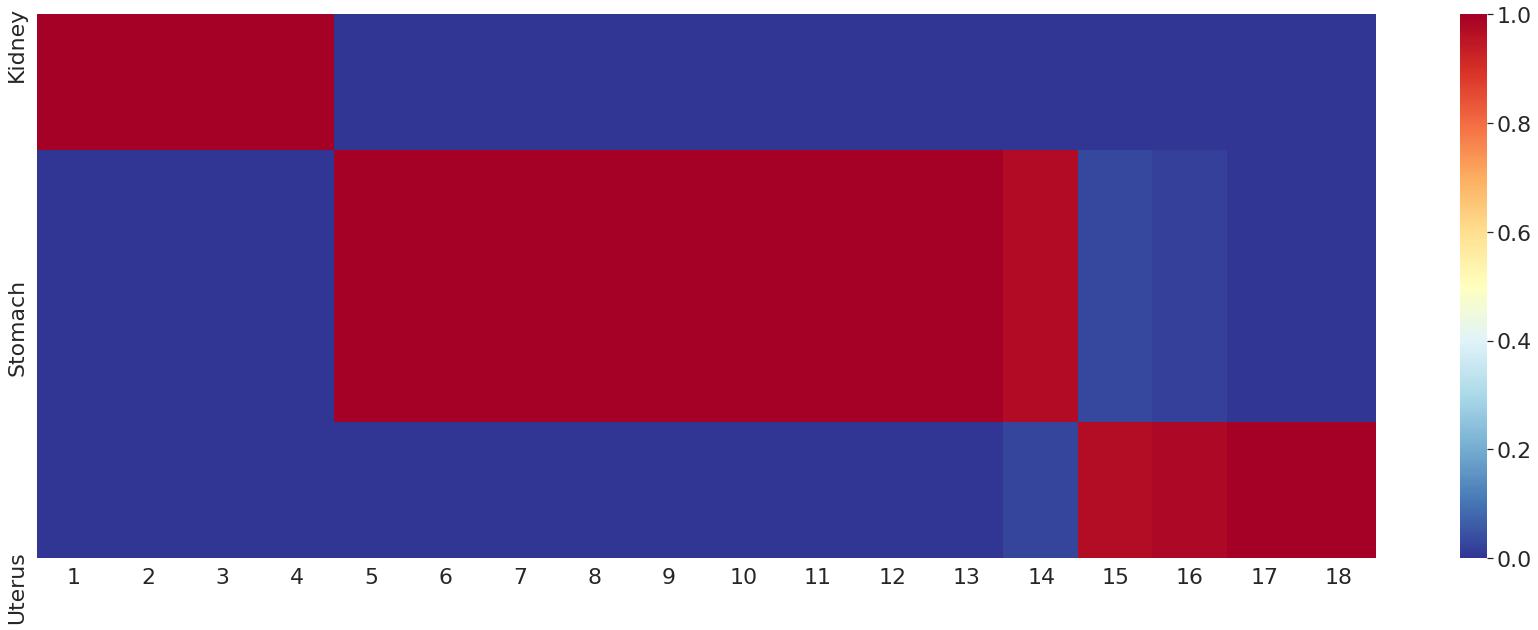

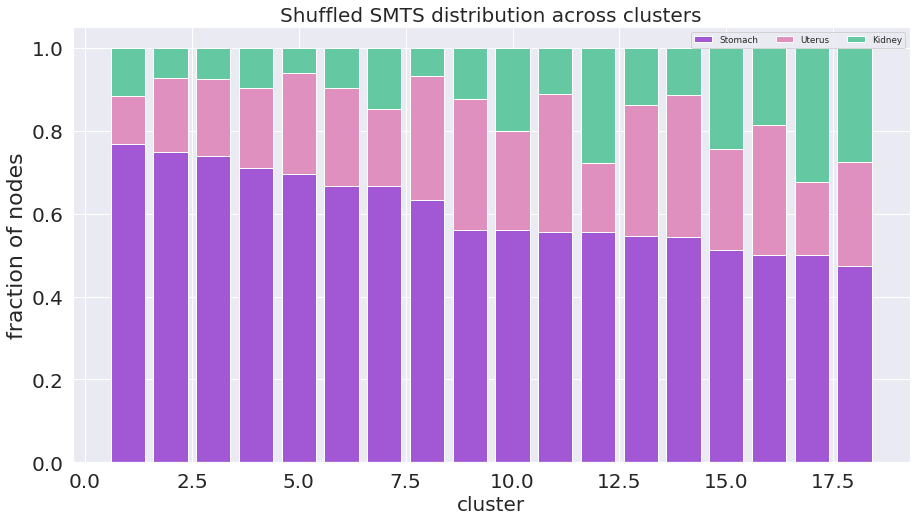

True SMTS 0


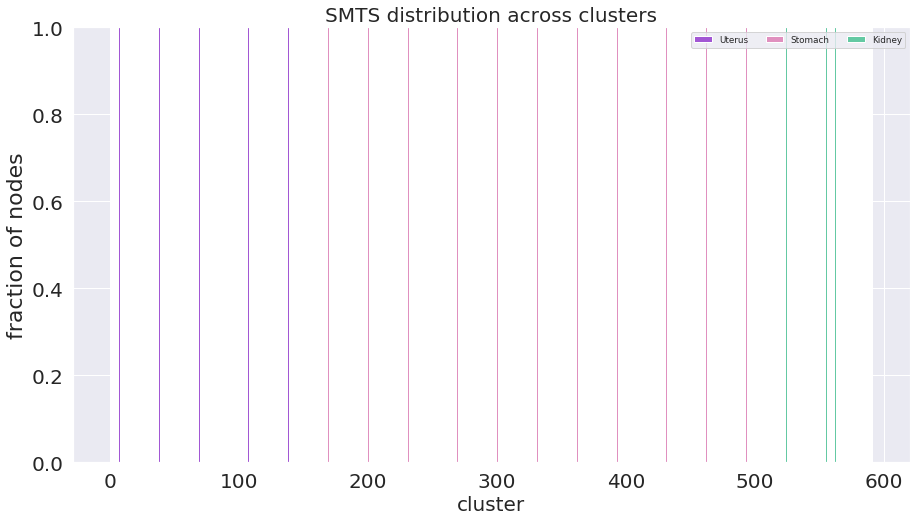

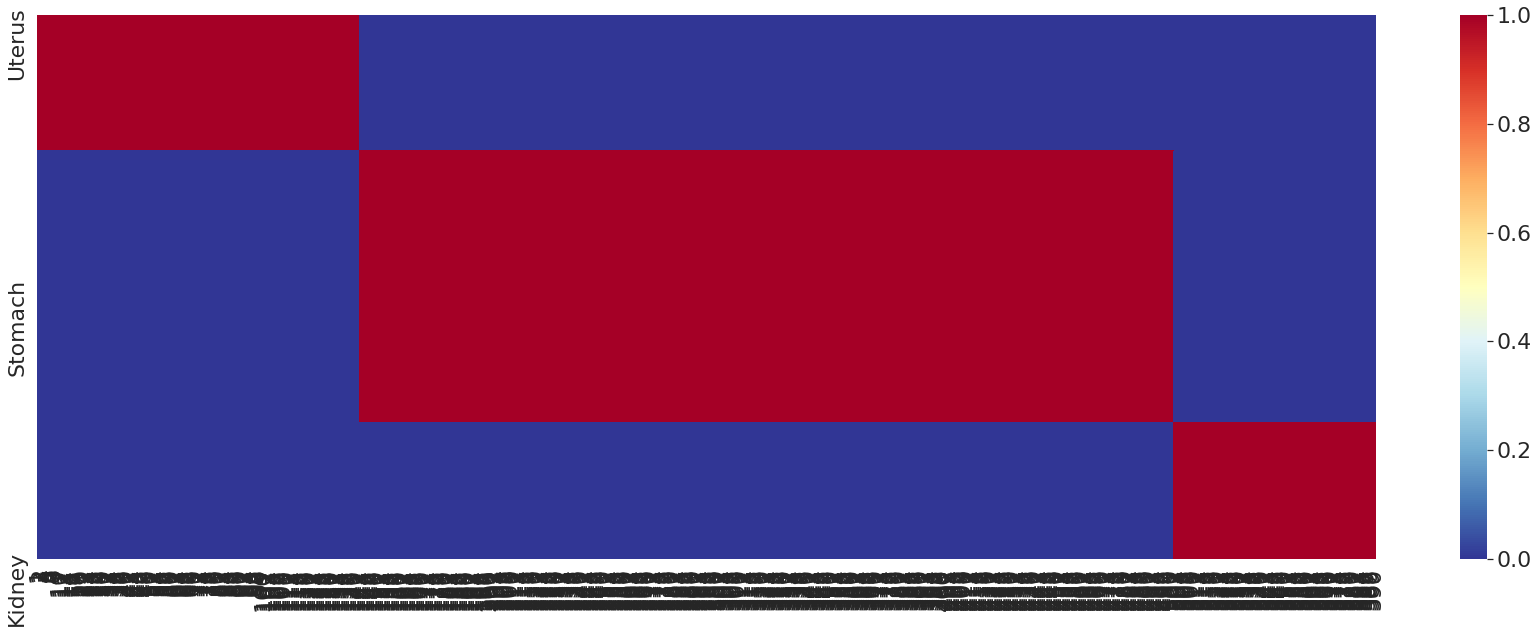

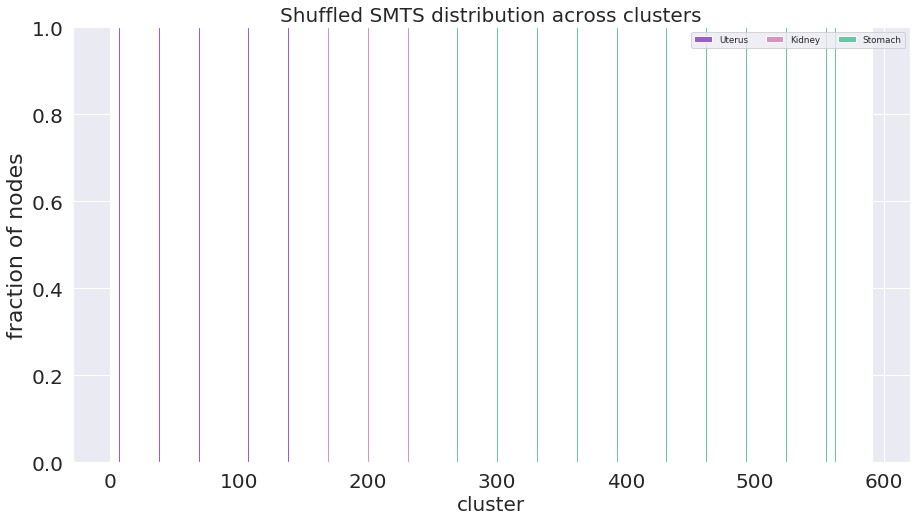

False SMTS 2


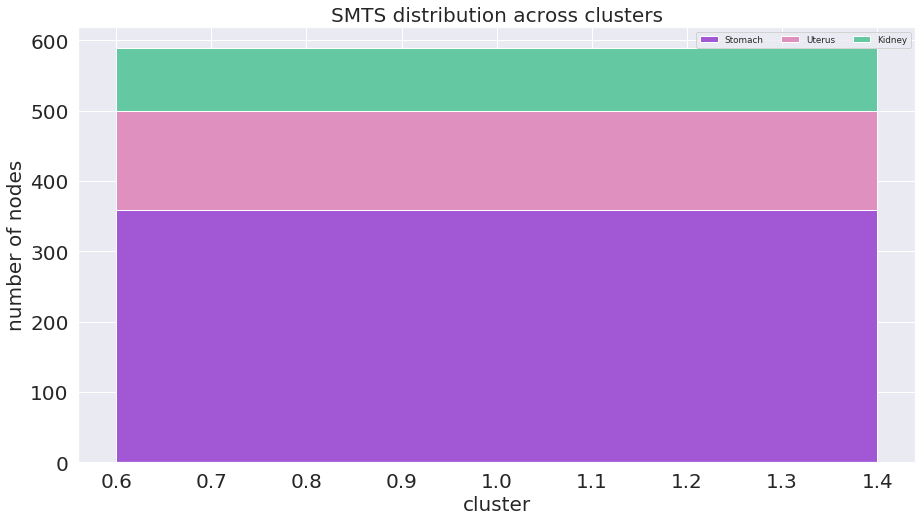

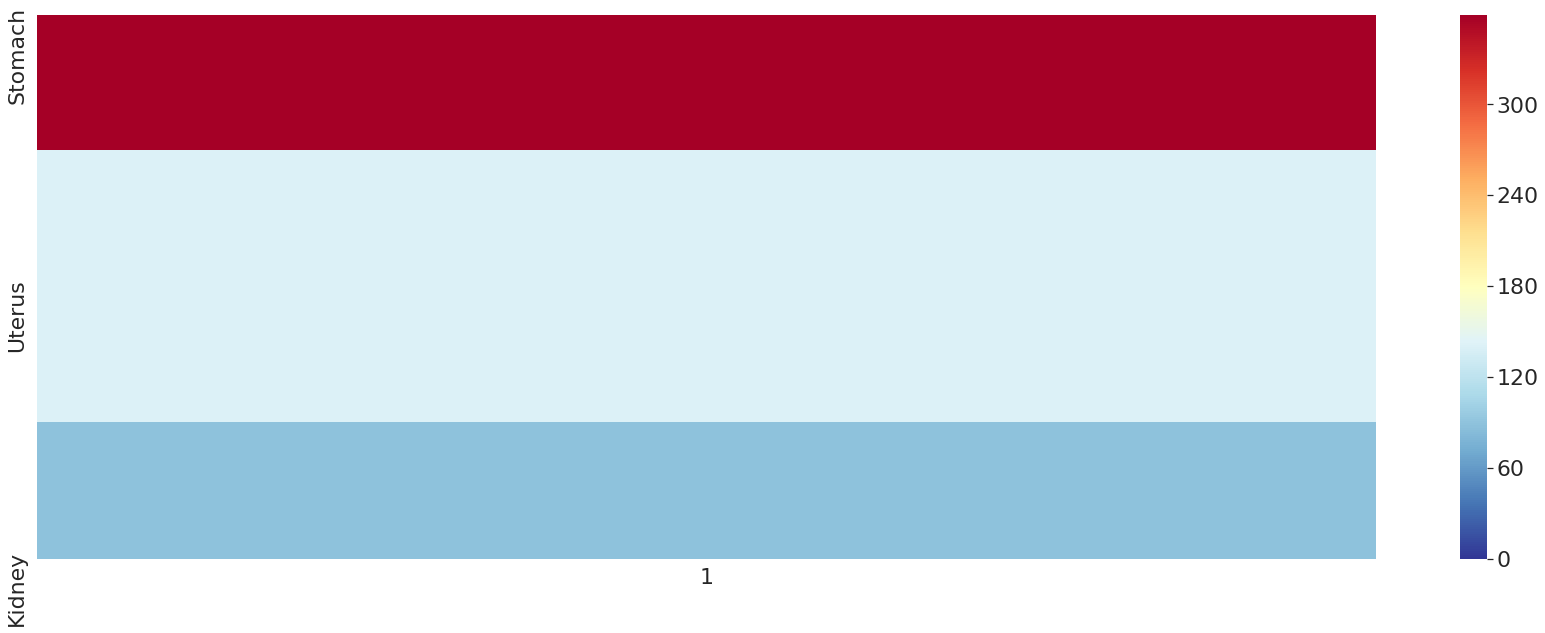

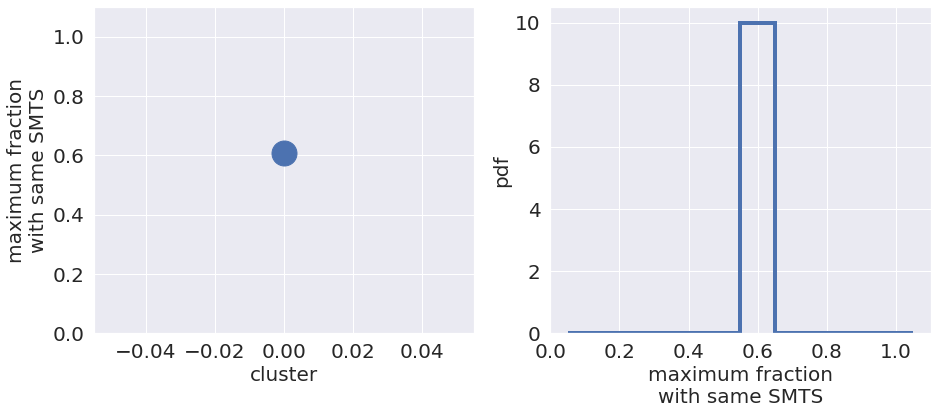

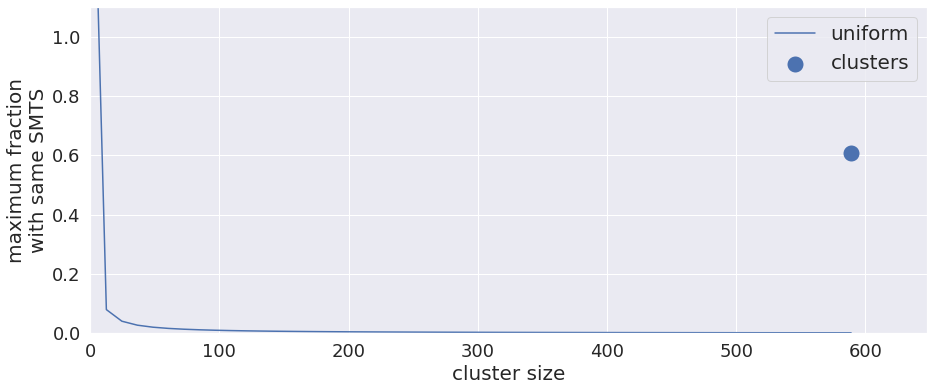

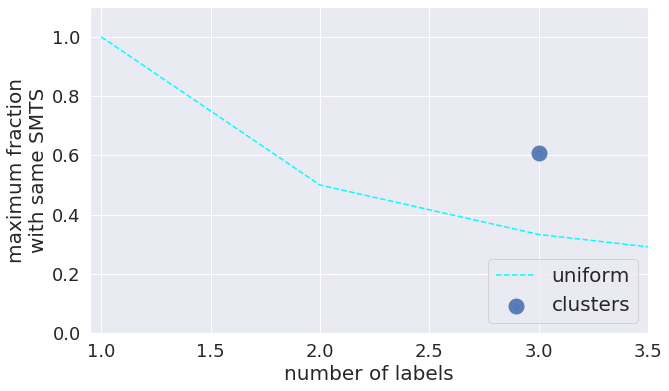

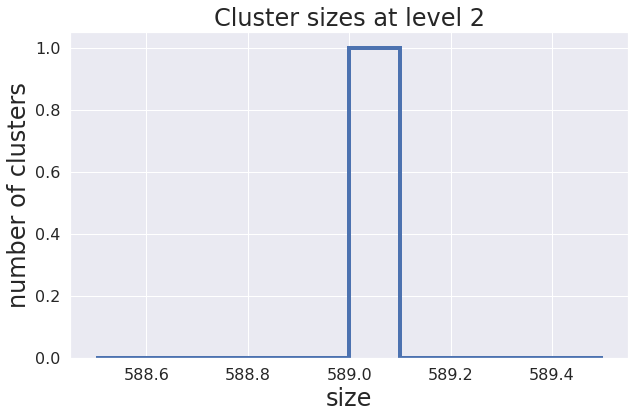

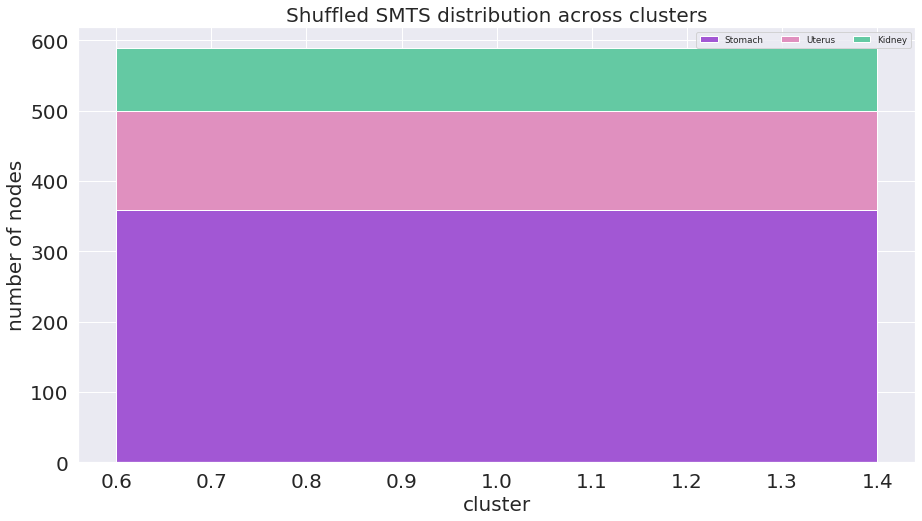

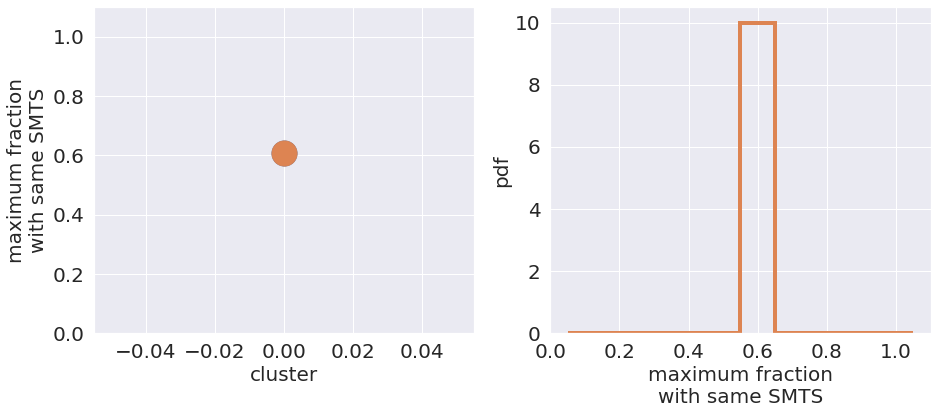

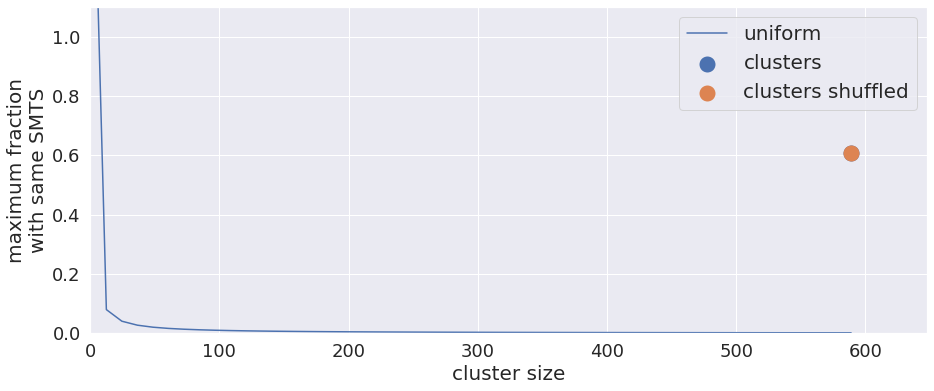

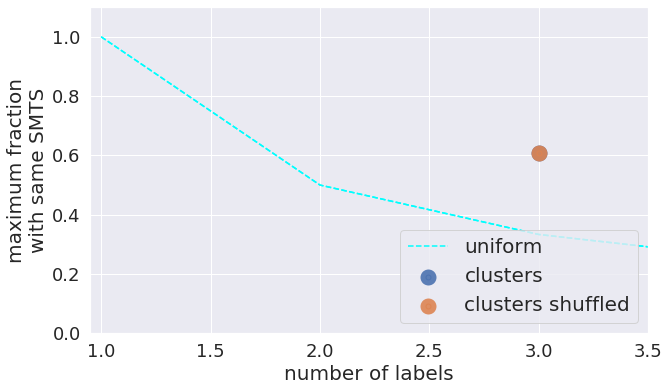

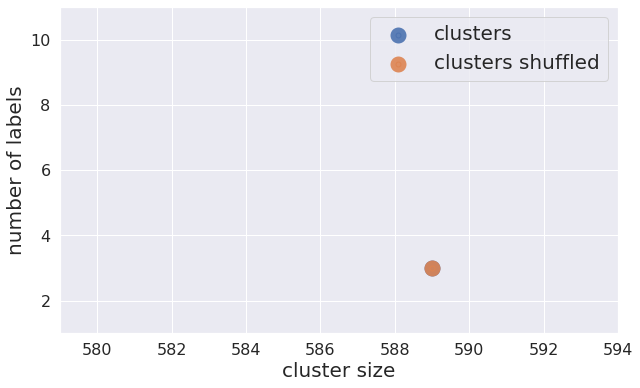

False SMTS 1


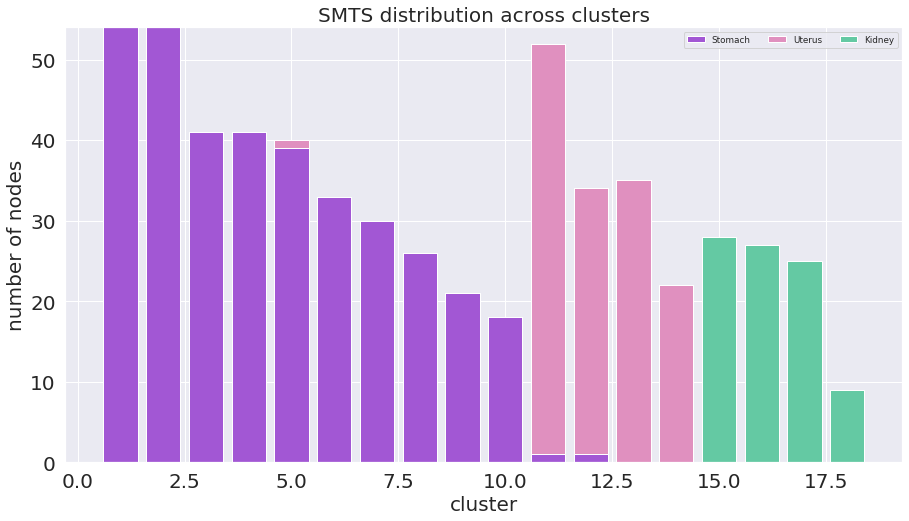

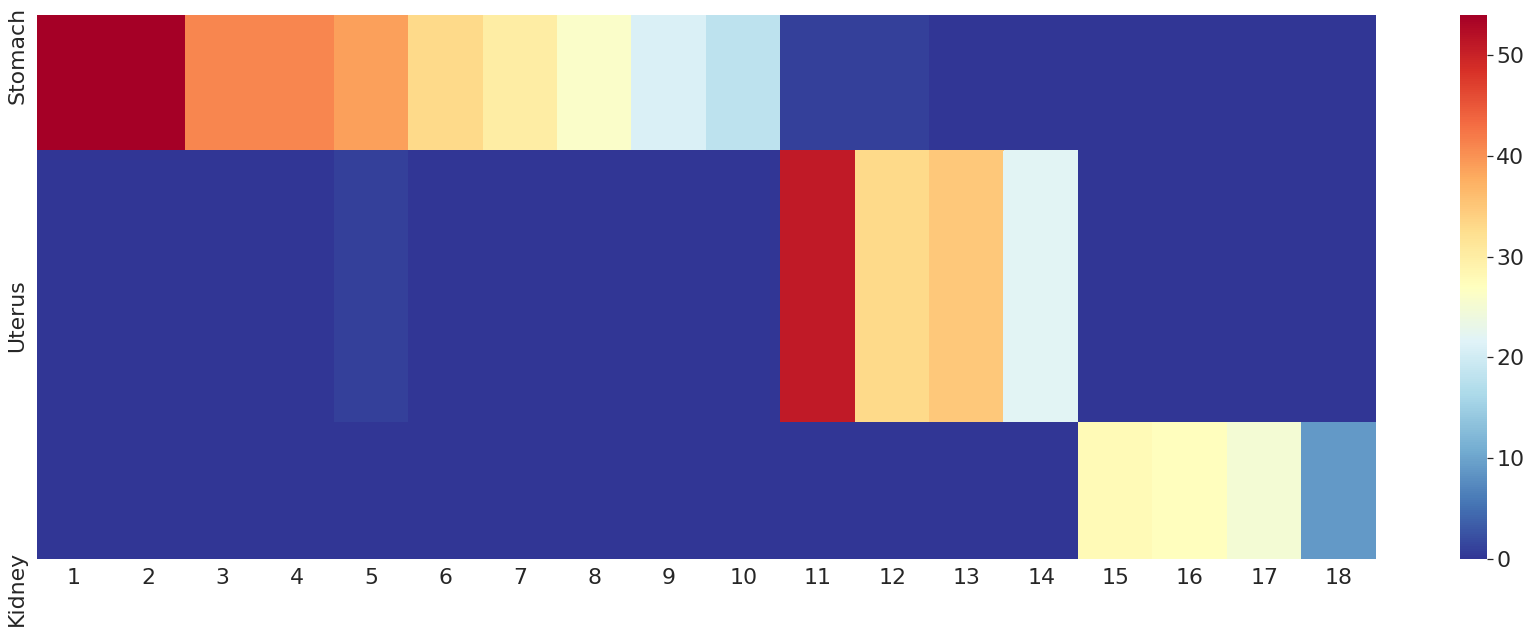

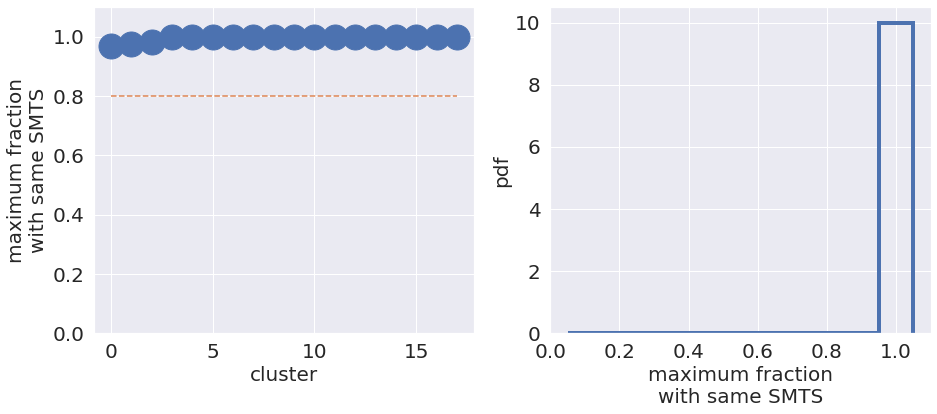

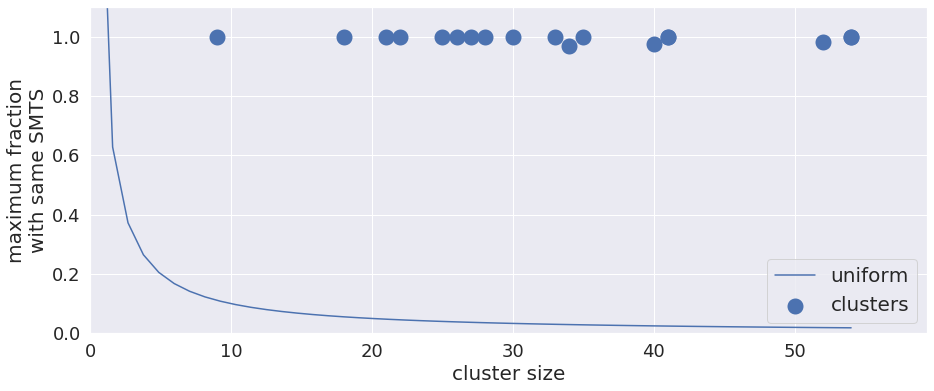

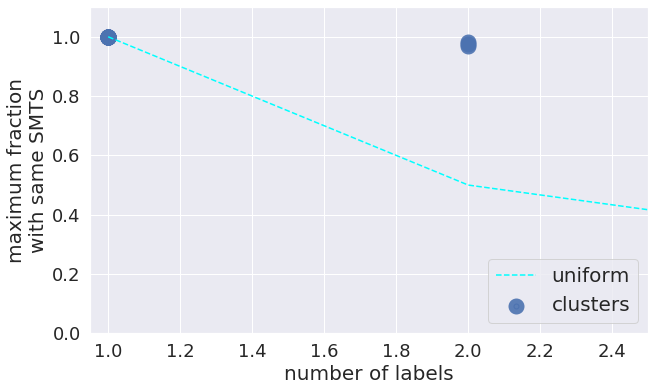

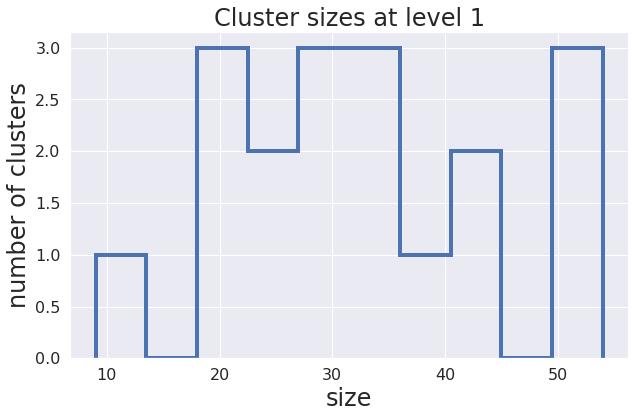

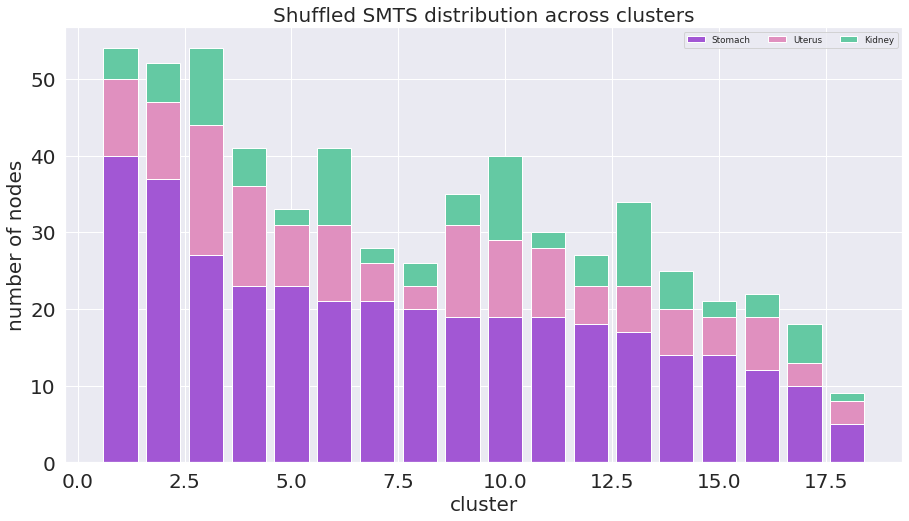

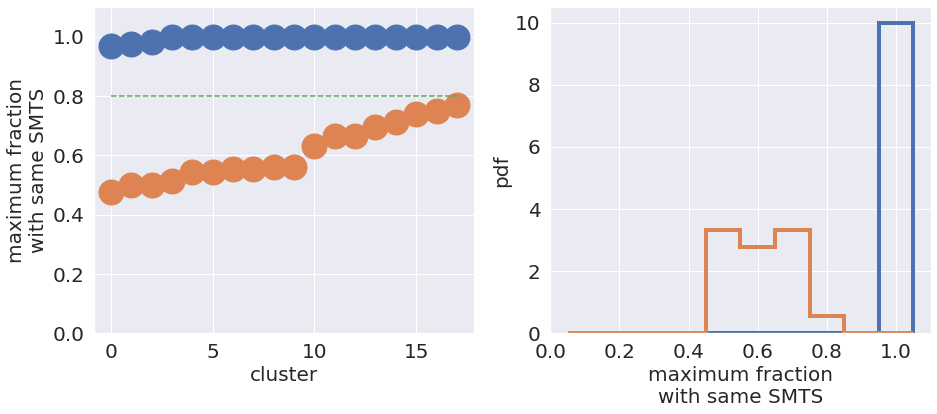

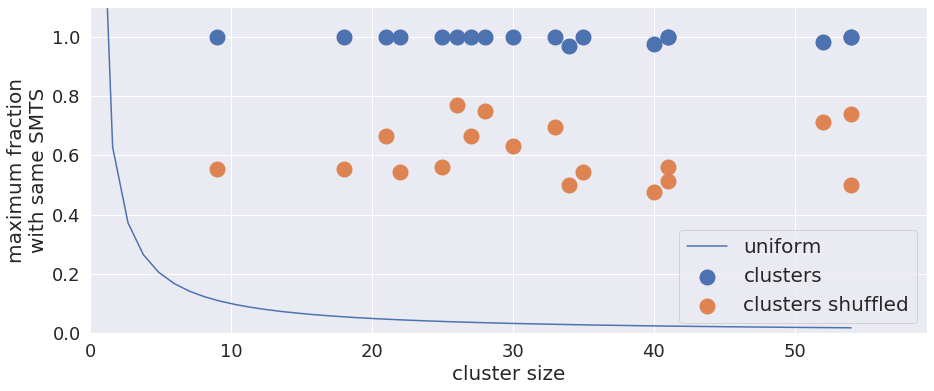

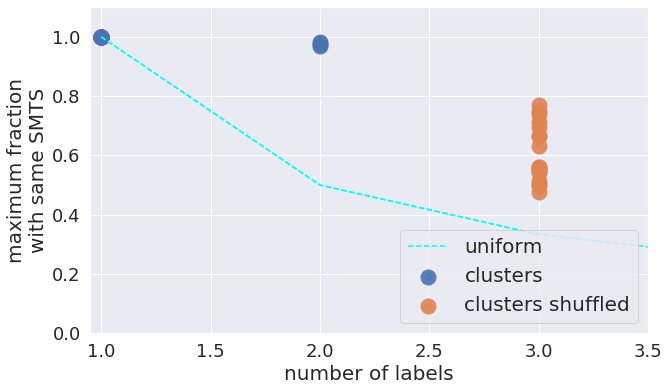

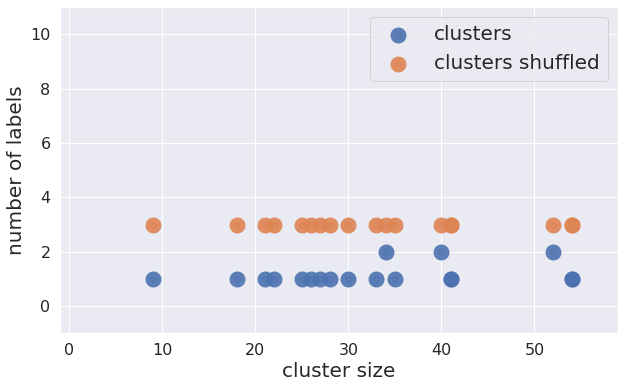

False SMTS 0


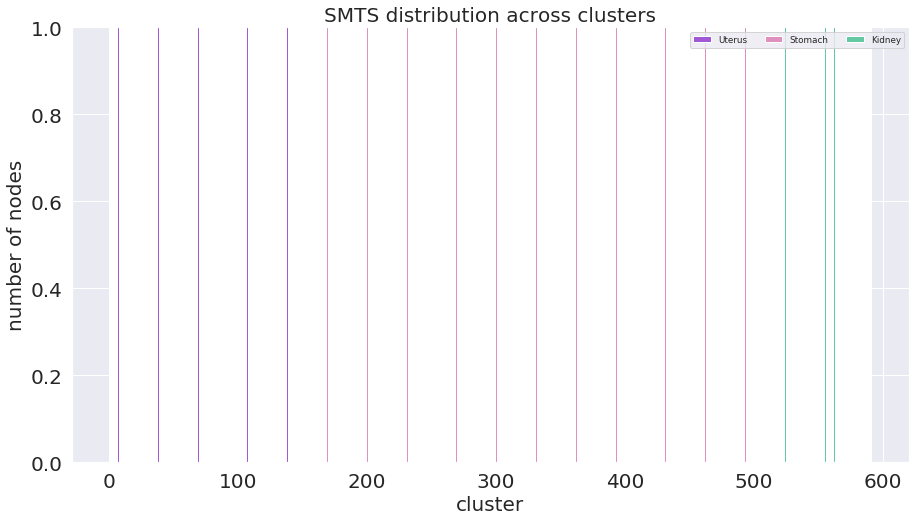

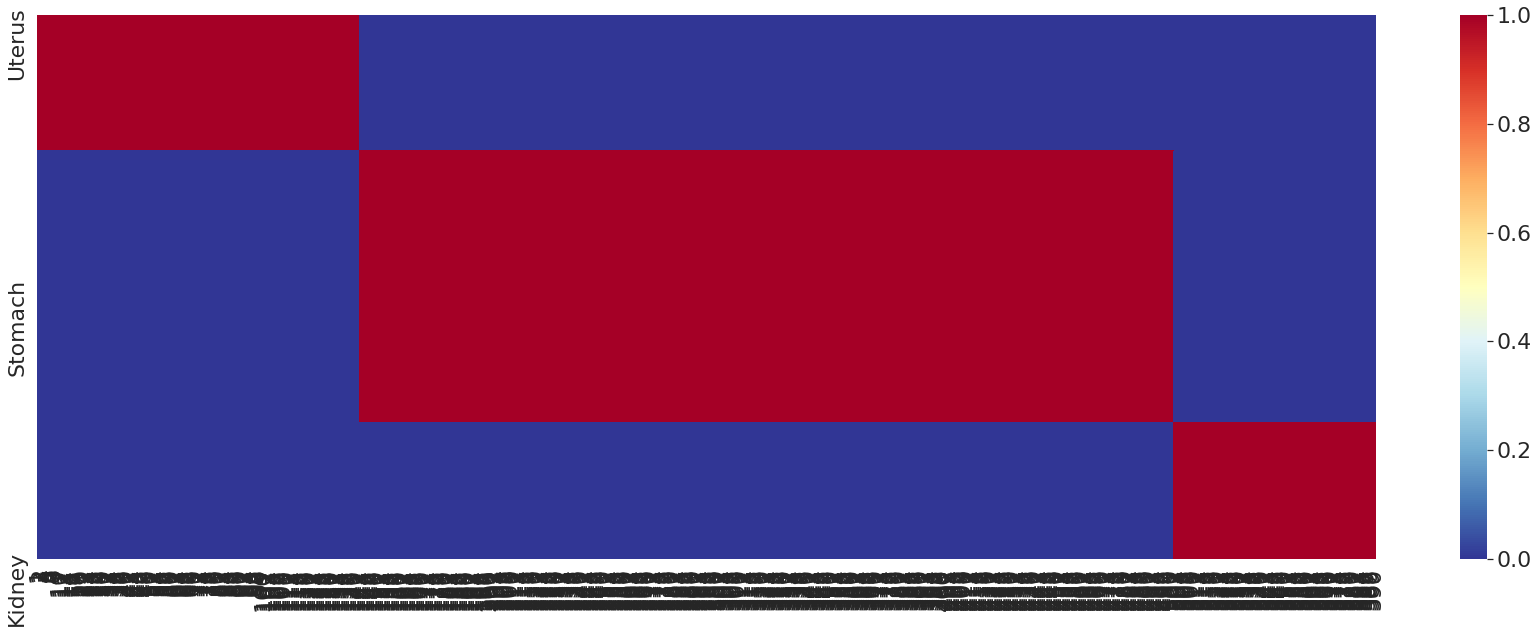

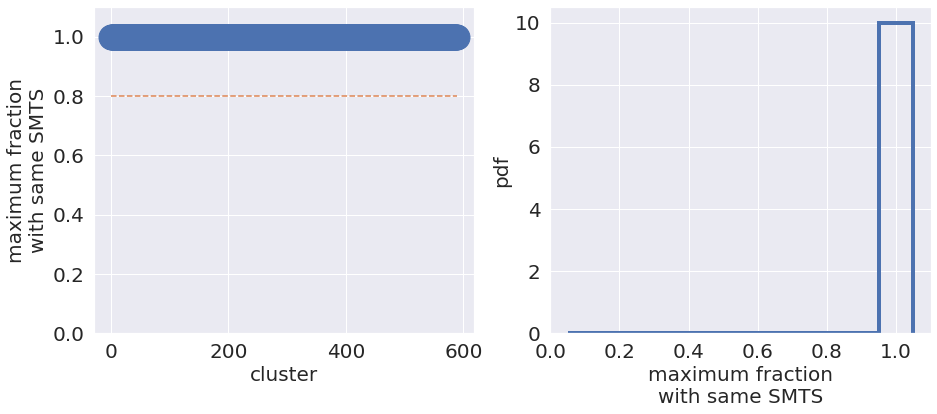

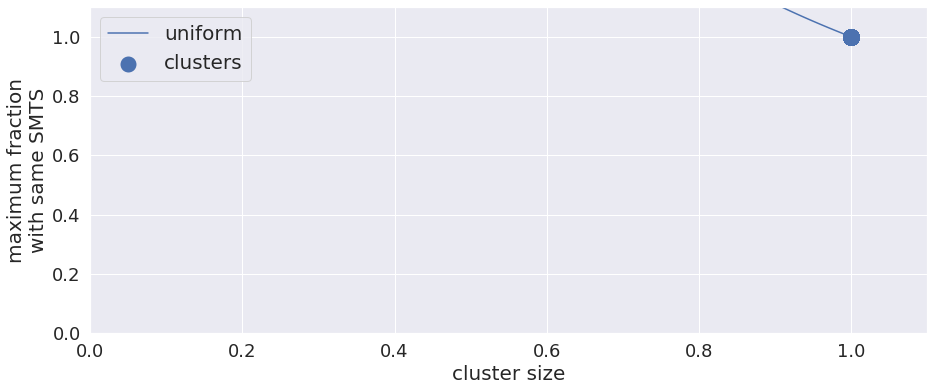

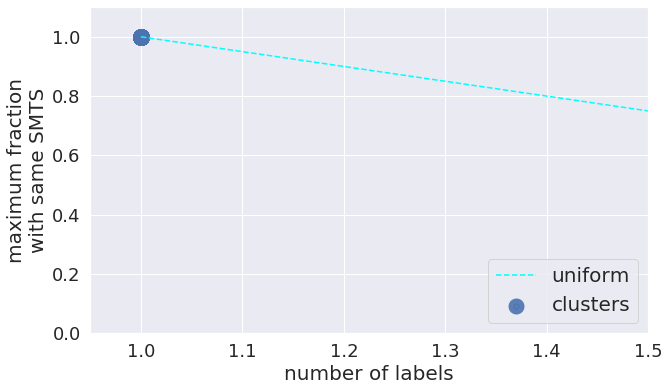

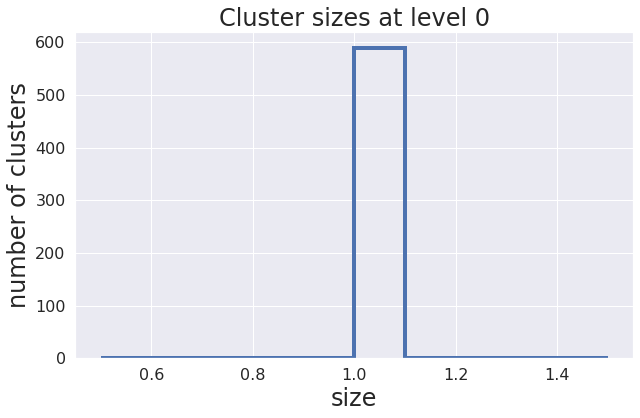

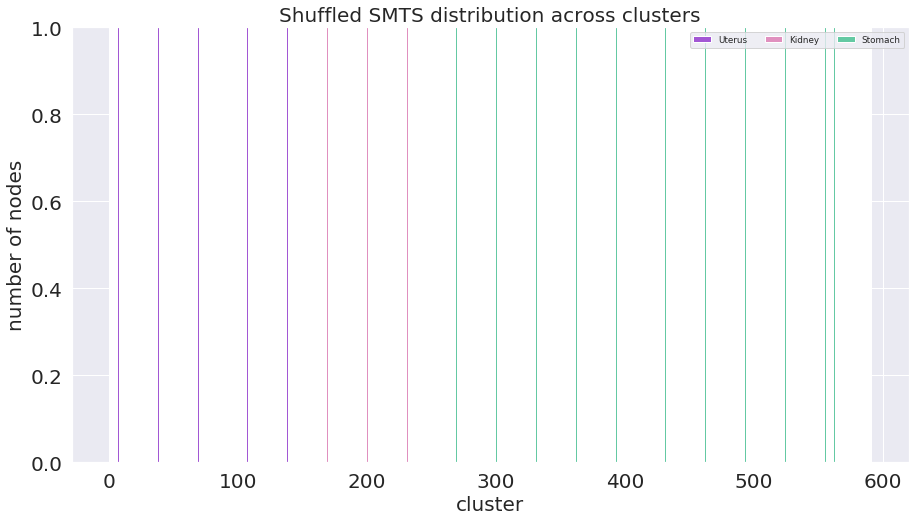

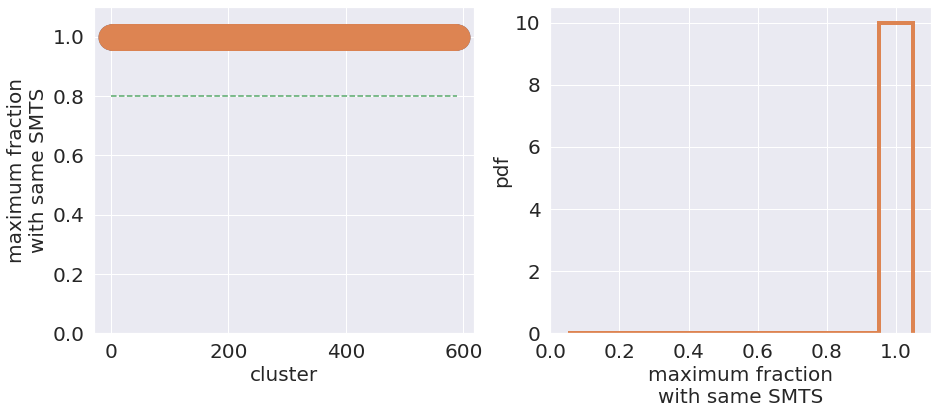

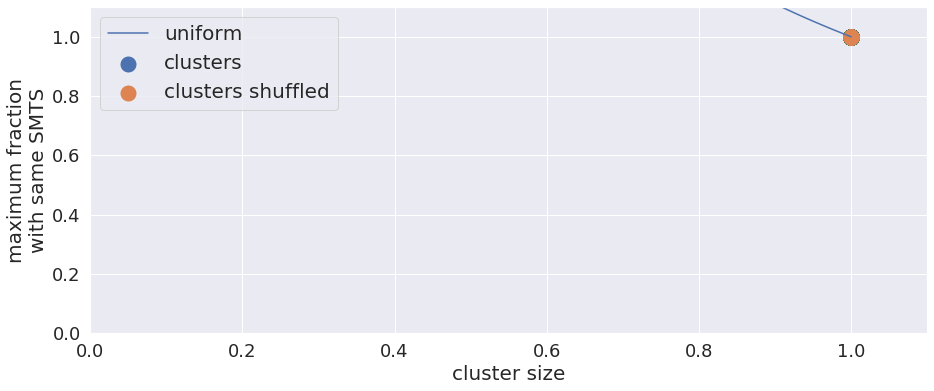

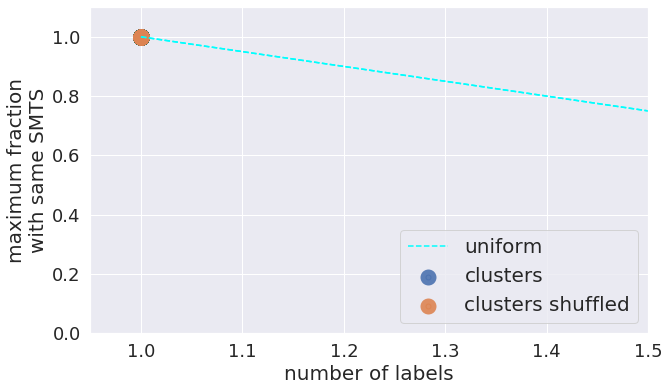

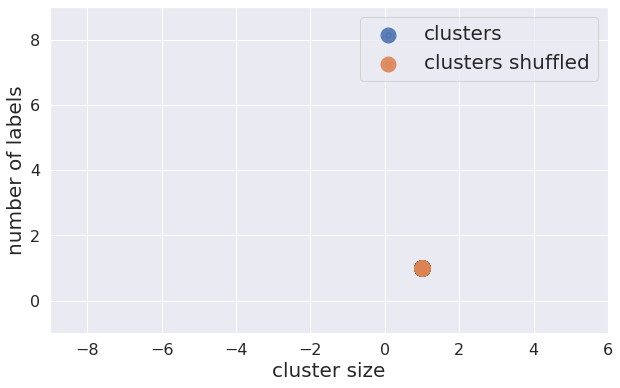

In [69]:
clusteranalysis(os.getcwd(),labels=['SMTS'], l_max=get_max_available_L(os.getcwd()))